# Modelos e Estratégias de Trading
## Aplicando um modelo VAR à PETR4

Uirá Caiado. 05 de Setembro, 2016

**Resumo**

*Neste projeto vou...*

## 1. Introdução

Nesta sessão vou ...


### 1.1. Modelagem ...

bla bla

In [3]:
import zipfile
s_fname = "data/petr4_0725_0818.zip"
archive = zipfile.ZipFile(s_fname, 'r')
def foo():
    f_total = 0.
    f_tot_rows = 0.
    for i, x in enumerate(archive.infolist()):
        f_total += x.file_size/ 1024.**2
        for num_rows, row in enumerate(archive.open(x)):
            f_tot_rows += 1
        print "{}:\t{:,.0f} rows\t{:0.2f} MB".format(x.filename, num_rows + 1, x.file_size/ 1024.**2)
    print '=' * 42
    print "TOTAL\t\t{} files\t{:0.2f} MB".format(i+1,f_total)
    print "\t\t{:0,.0f} rows".format(f_tot_rows)
    return x

%time x = foo()

20160725.csv:	117,170 rows	4.66 MB
20160726.csv:	105,898 rows	4.20 MB
20160727.csv:	131,058 rows	5.22 MB
20160728.csv:	117,286 rows	4.65 MB
20160729.csv:	145,368 rows	5.79 MB
20160801.csv:	114,815 rows	4.57 MB
20160802.csv:	113,642 rows	4.51 MB
20160803.csv:	142,283 rows	5.69 MB
20160804.csv:	144,832 rows	5.78 MB
20160805.csv:	117,901 rows	4.70 MB
20160808.csv:	93,502 rows	3.70 MB
20160809.csv:	86,078 rows	3.41 MB
20160810.csv:	112,320 rows	4.46 MB
20160811.csv:	153,925 rows	6.16 MB
20160812.csv:	154,212 rows	6.17 MB
20160815.csv:	114,955 rows	4.57 MB
20160816.csv:	111,913 rows	4.45 MB
20160817.csv:	122,047 rows	4.86 MB
20160818.csv:	90,024 rows	3.56 MB
TOTAL		19 files	91.09 MB
		2,289,229 rows
CPU times: user 6.9 s, sys: 28 ms, total: 6.93 s
Wall time: 6.92 s


In [4]:
import pandas as pd
df = pd.read_csv(archive.open(x), index_col=0, parse_dates=['Date'])
df.head()

,Date,Type,Price,Size
0,2016-08-18 10:09:09,TRADE,12.80,1000
1,2016-08-18 10:09:09,BID,12.80,15900
2,2016-08-18 10:09:09,ASK,12.81,2900
3,2016-08-18 10:09:09,ASK,12.81,7900
4,2016-08-18 10:09:09,BID,12.80,20900


In [5]:
import pandas as pd

df_all = None

for i, x in enumerate(archive.infolist()):
    df = pd.read_csv(archive.open(x), index_col=0, parse_dates=['Date'])
    ts_date = df.Date[0].date()
    df.Date = ["{:%H:%M:%S}".format(x) for x in df.Date]
    df = df[df.Type == "TRADE"]
    df = pd.DataFrame(df.groupby('Date').last()['Price'])
    if i == 0:
        df_all = df.copy()
        df_all.columns = [ts_date] 
    else:
        df_aux = df.copy()
        df_aux.columns = [ts_date]
        df_all = df_all.join(df_aux)
df_all.index = pd.to_datetime(df_all.index)
df_all = df_all.fillna(method='ffill')
df_all = df_all.dropna()

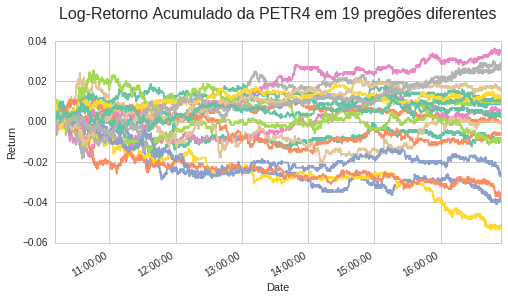

In [11]:
import numpy as np
df_logrtn = np.log(df_all/df_all.shift())
df_logrtn = df_logrtn[[(x.hour*60 + x.minute) < (16*60 + 55) for x in df_logrtn.index]]
ax = df_logrtn.cumsum().plot(legend=False)
ax.set_title(u'Log-Retorno Acumulado da PETR4 em 19 pregões diferentes\n', fontsize=16)
ax.set_ylabel('Return');

## 2. Implementando o Modelo

Nesta sessão detalharemos e implementaremos ...

### 2.1. Bla

bla bla


## 4. Conclusão

bla bla




## 5. Últimas Considerações

bla bla


*Style notebook and change matplotlib defaults*

In [1]:
#loading style sheet
from IPython.core.display import HTML
HTML(open('ipython_style.css').read())

In [7]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Set2", 10))